# Getting started with calibrated-explanations
Author: Tuwe Löfström (tuwe.lofstrom@ju.se)  
Copyright 2023 Tuwe Löfström  
License: BSD 3 clause
## Classification
Let us illustrate how we may use `calibrated_explanations` to generate explanations from a classifier trained on a dataset from
[www.openml.org](https://www.openml.org), which we first split into a
training and a test set using `train_test_split` from
[sklearn](https://scikit-learn.org), and then further split the
training set into a proper training set and a calibration set:

In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

dataset = fetch_openml(name="wine", version=7, as_frame=True, parser='auto')

X = dataset.data.values.astype(float)
y = (dataset.target.values == 'True').astype(int)

feature_names = dataset.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2,stratify=y)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train,
                                                            test_size=0.25)


We now fit a model on our data. 

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1)

rf.fit(X_prop_train, y_prop_train)

RandomForestClassifier(n_jobs=-1)

Let us explain a test instance using the `CalibratedExplainer` class in `calibrated_explanations`. The method used to get factual explanations is `explain_factual`.

In [46]:
from calibrated_explanations import CalibratedExplainer, __version__

explainer = CalibratedExplainer(rf, X_cal, y_cal, feature_names=feature_names)

factual_explanations = explainer.explain_factual(X_test)

display(explainer)

print(f"calibrated_explanations {__version__}")

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


CalibratedExplainer(mode=classification, discretizer=BinaryEntropyDiscretizer(), learner=RandomForestClassifier(n_jobs=-1))

calibrated_explanations v0.5.1


Once we have the explanations, we can plot all of them using `plot`. Default, a regular plot, without uncertainty intervals included, is created. To include uncertainty intervals, change the parameter `uncertainty=True`. To plot only a single instance, the `plot` function can be called, submitting the index of the test instance to plot.

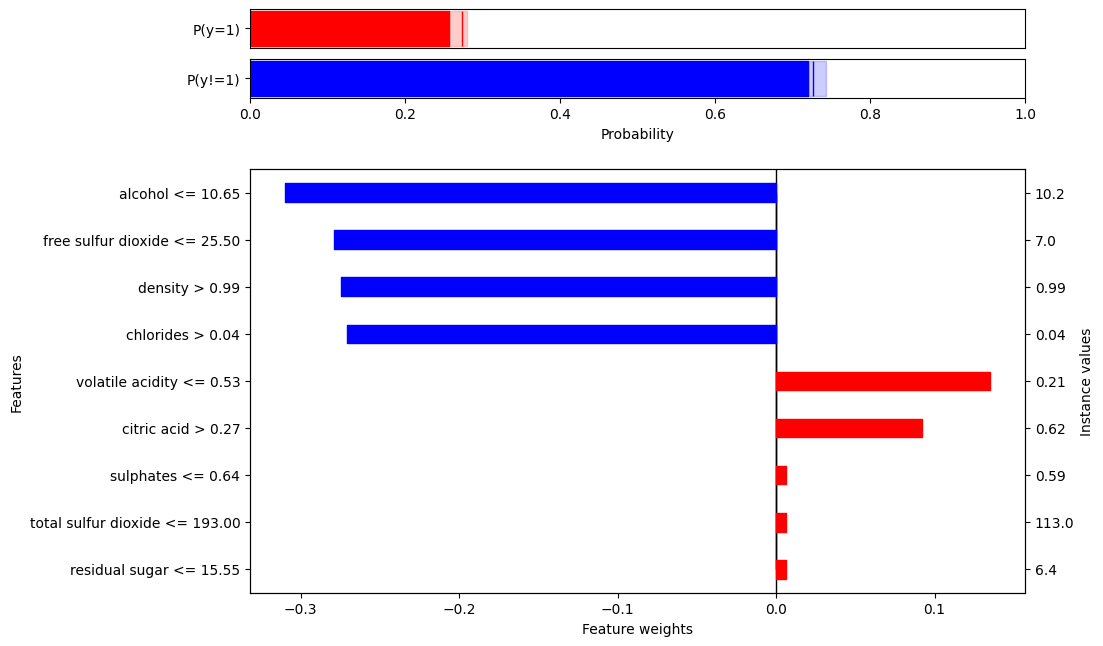

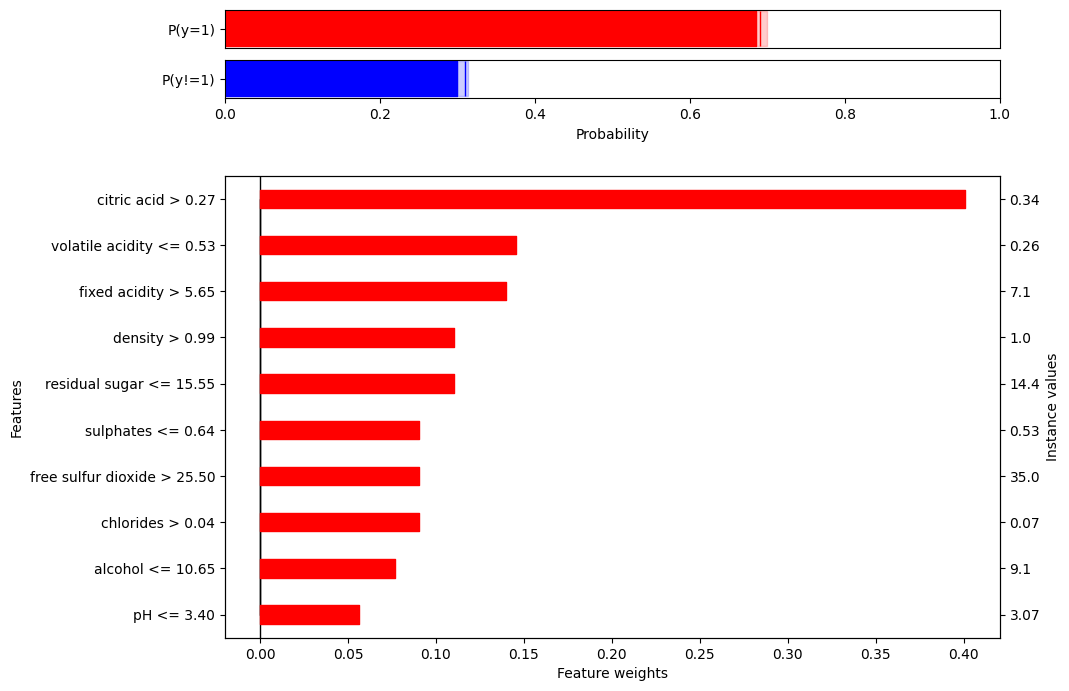

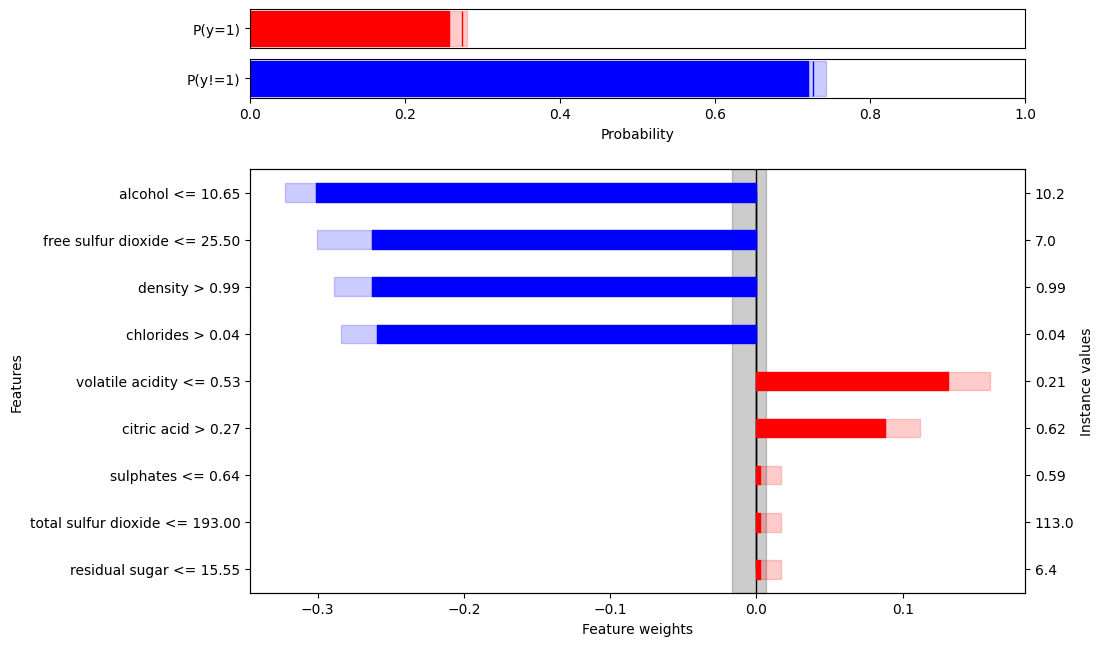

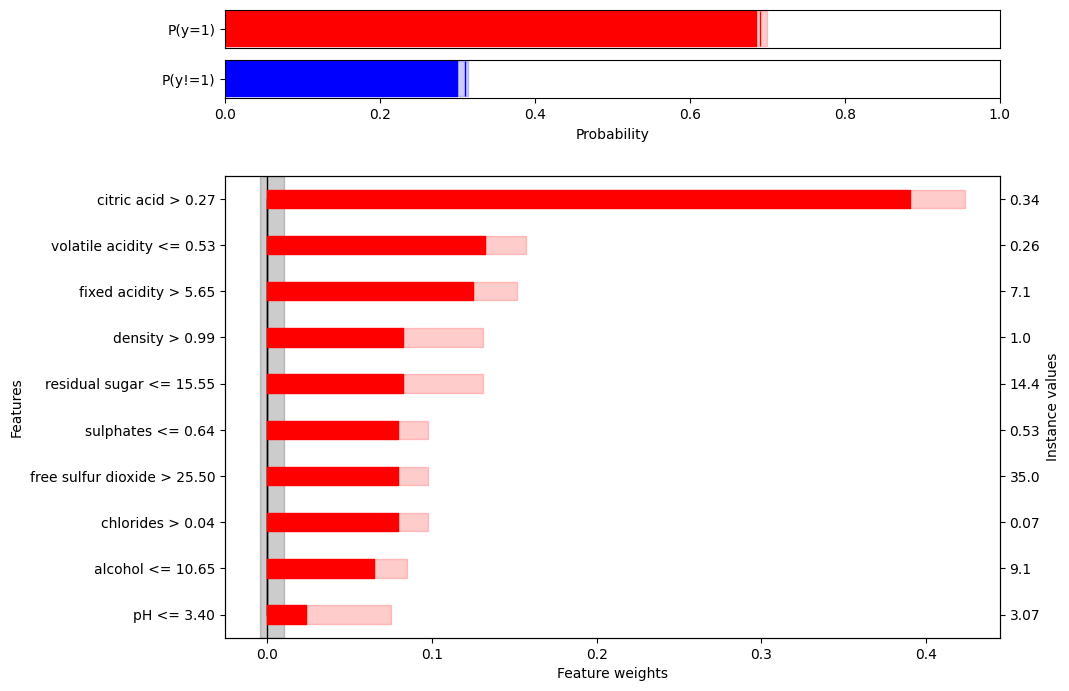

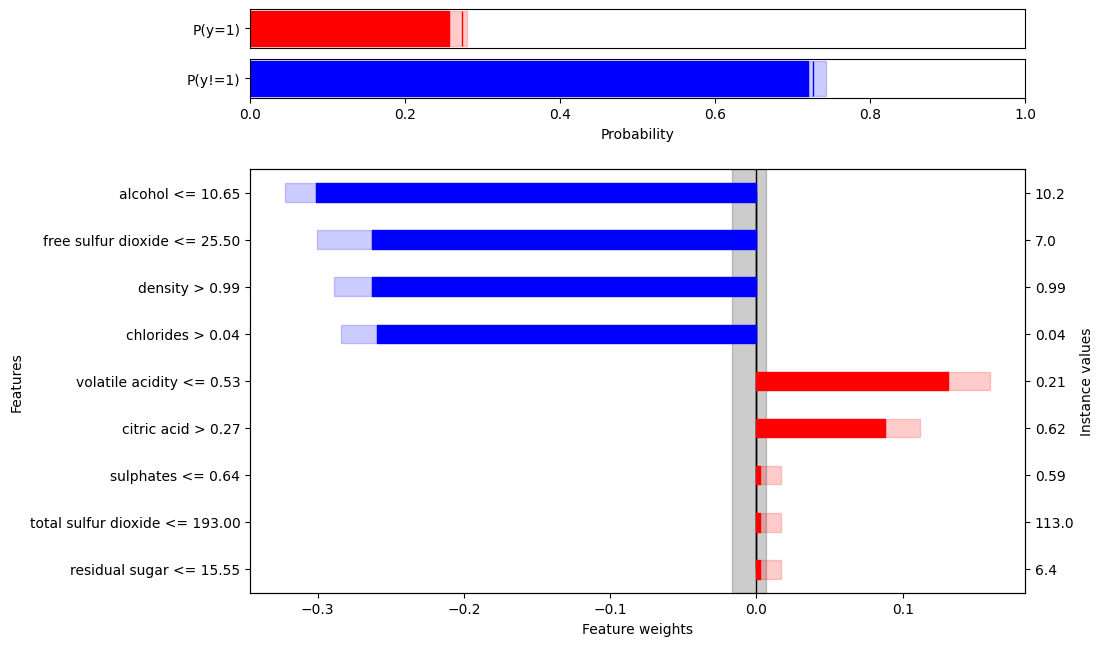

In [47]:
factual_explanations.plot()
factual_explanations.plot(uncertainty=True)

factual_explanations.plot(0, uncertainty=True)

You can also add and remove conjunctive rules.

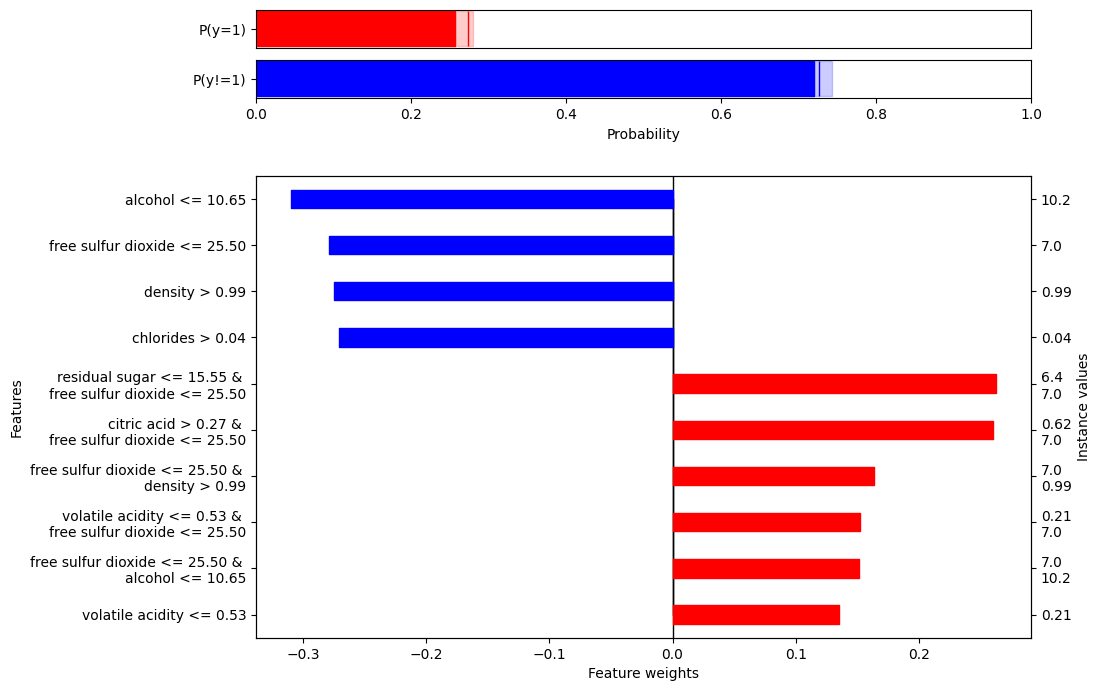

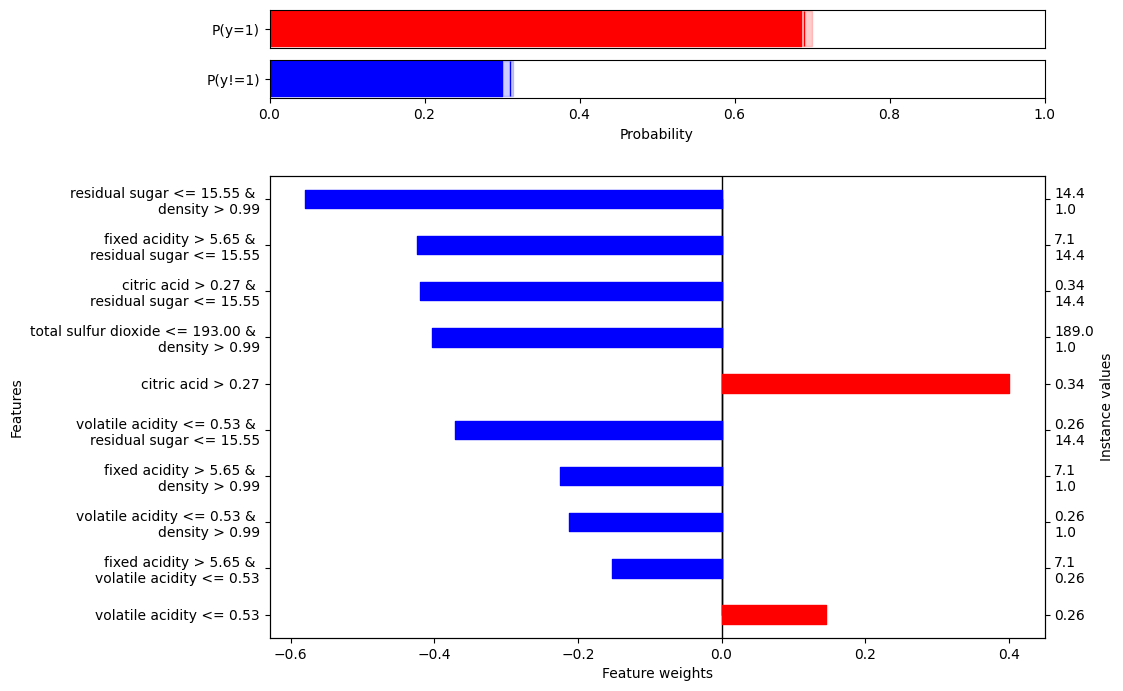

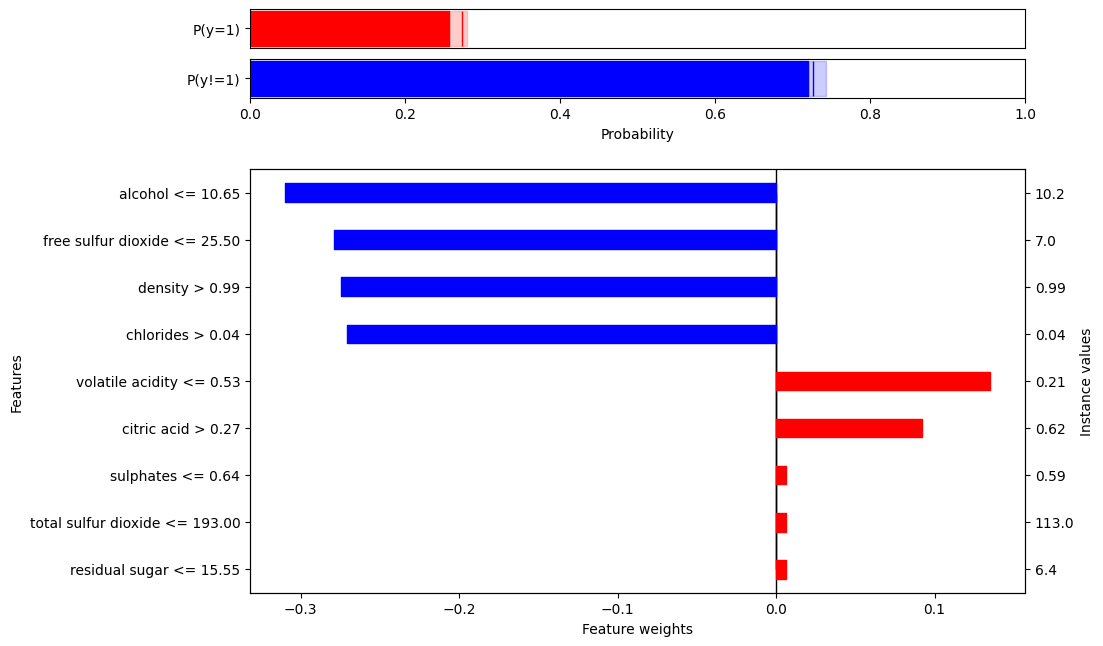

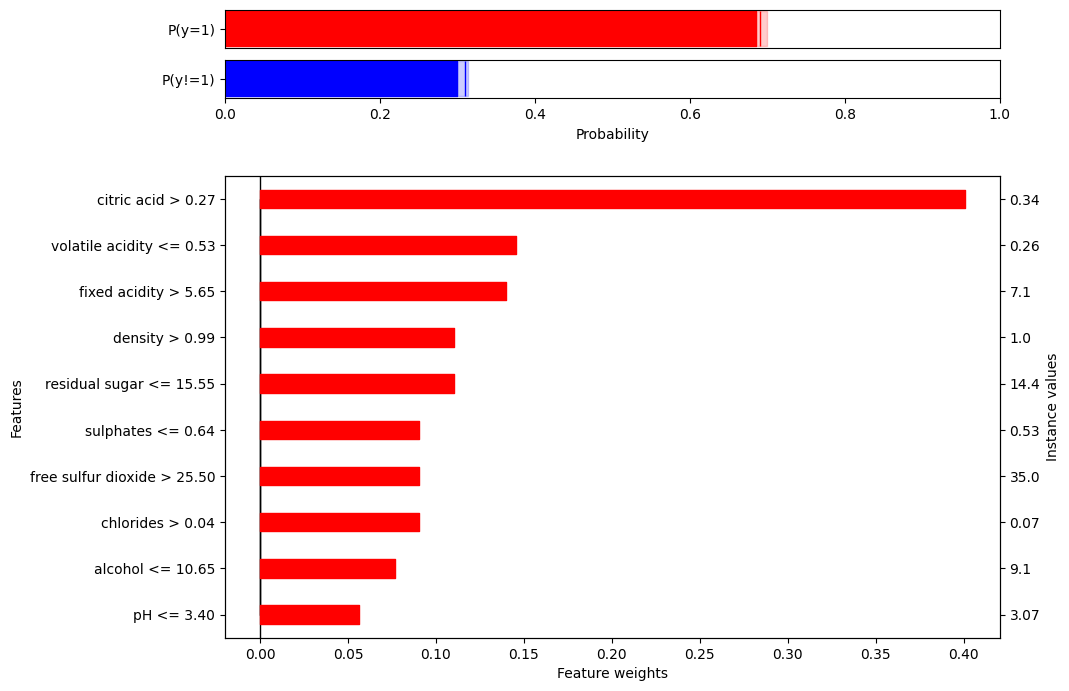

In [48]:

factual_explanations.add_conjunctions().plot()
factual_explanations.remove_conjunctions().plot()

#### Alternative Explanations
An alternative to factual rules is to extract alternative rules. 
`explore_alternatives` can be called to get alternative rules with an appropriate discretizer automatically assigned. An alternative is to first change the discretizer to `entropy` (for classification) and then call the `CalibratedExplainer` object as above.  

In [49]:
alternative_explanations = explainer.explore_alternatives(X_test)
display(explainer)

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


CalibratedExplainer(mode=classification, discretizer=EntropyDiscretizer(), learner=RandomForestClassifier(n_jobs=-1))

Alternatives are also visualized using the `plot`. Plotting an individual alternative explanation is done using `plot`, submitting the index to plot. Adding or removing conjunctions is done as before. 

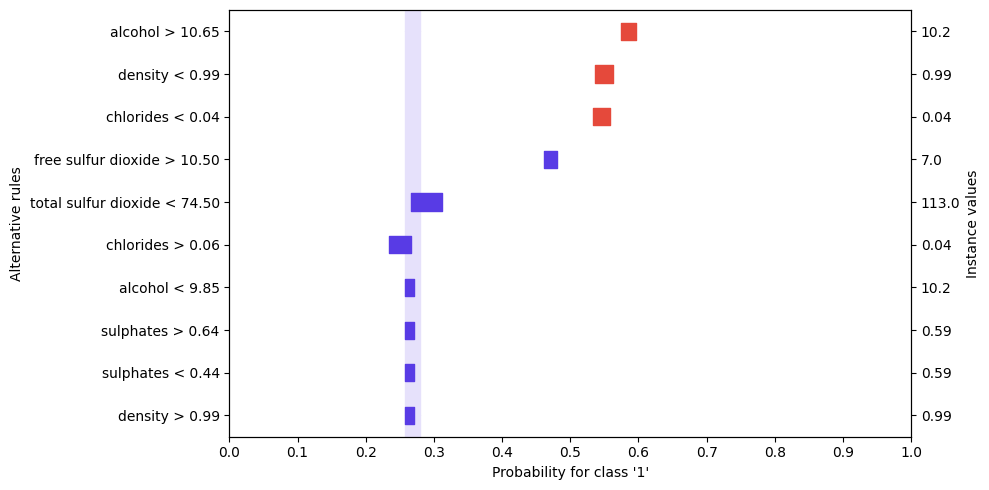

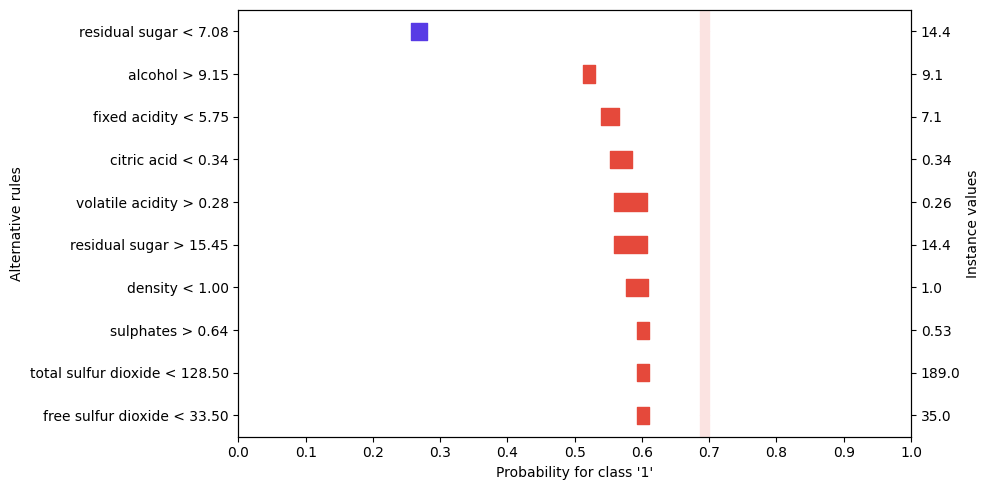

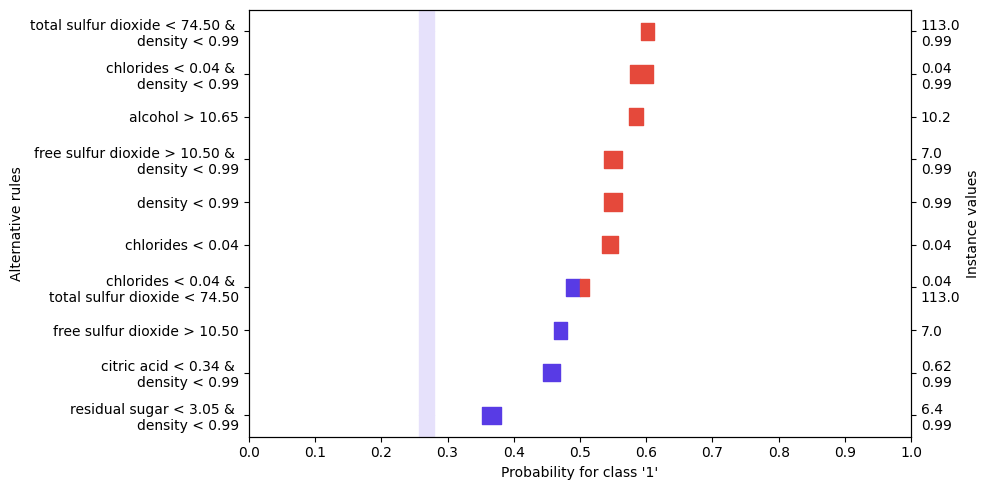

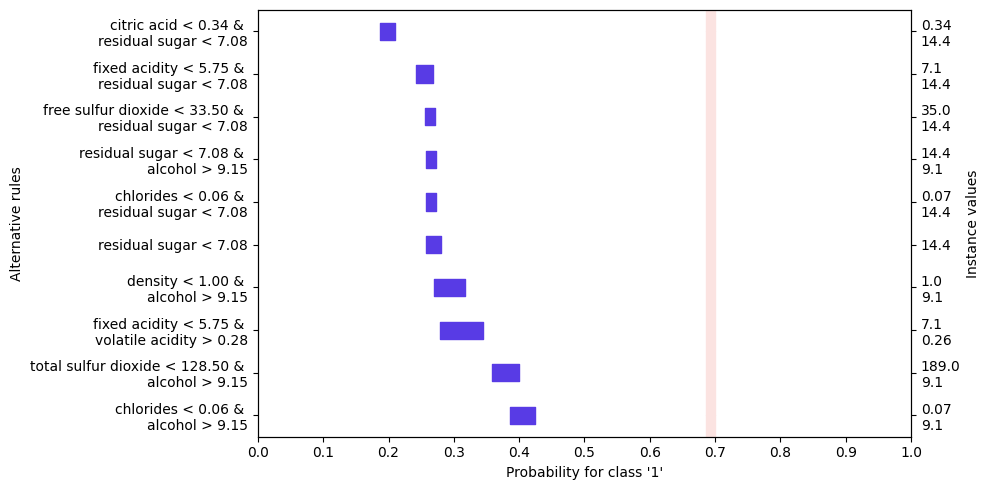

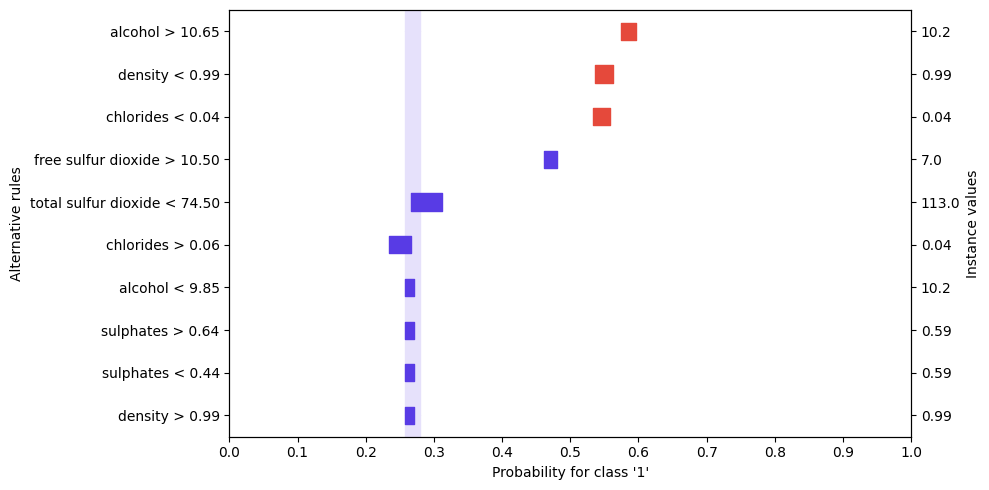

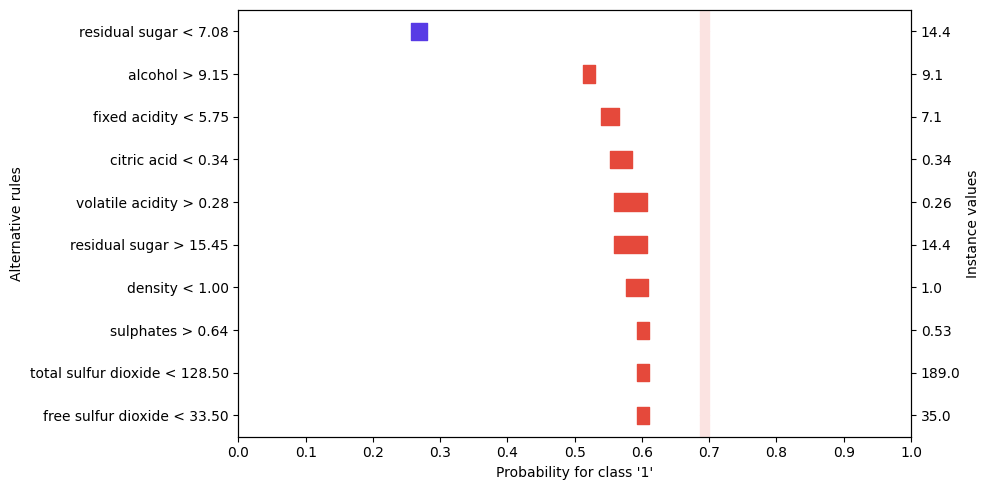

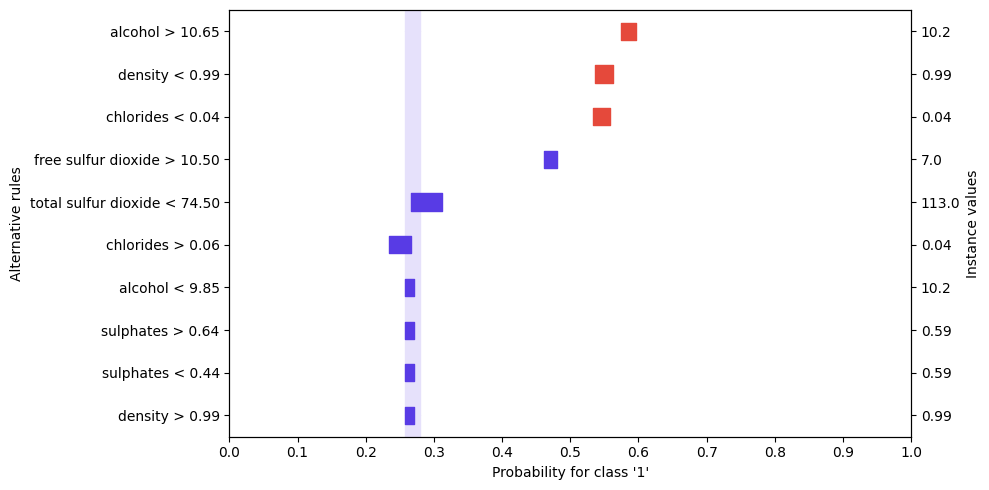

In [50]:
alternative_explanations.plot()
alternative_explanations.add_conjunctions().plot()
alternative_explanations.remove_conjunctions().plot()

alternative_explanations.plot(0)

`calibrated_explanations` supports multiclass which is demonstrated in [demo_multiclass](https://github.com/Moffran/calibrated_explanations/blob/main/notebooks/demo_multiclass.ipynb). That notebook also demonstrates how both feature names and target and categorical labels can be added to improve the interpretability. 
## Regression
Extracting explanations for regression is very similar to how it is done for classification. First we load and divide the dataset.   

In [51]:
dataset = fetch_openml(name="house_sales", version=3)

X = dataset.data.values.astype(float)
y = dataset.target.values/1000
y_filter = y < 500
X = X[y_filter,:]
y = y[y_filter]

feature_names = dataset.feature_names
categorical_labels = {5:{0: 'False', 1: 'True'}}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2, random_state=42, stratify=X[:,5])

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train, random_state=42,
                                                            test_size=500, stratify=X_train[:,5])

Let us now fit a `RandomForestRegressor` from
[sklearn](https://scikit-learn.org) to the proper training
set:

In [52]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_prop_train, y_prop_train)

RandomForestRegressor()

#### Factual Explanations
Define a `CalibratedExplainer` object using the new model and data. The `mode` parameter must be explicitly set to regression. By default, explanations based on a two-sided interval with 90% confidence are provided. 

In [53]:
from crepes.extras import DifficultyEstimator
explainer = CalibratedExplainer(rf, X_cal, y_cal, mode='regression', feature_names=feature_names, categorical_labels=categorical_labels)
explainer.set_difficulty_estimator(DifficultyEstimator().fit(X=X_train, learner=rf, scaler=True))

factual_explanations = explainer.explain_factual(X_test)

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Regression also offer both regular and uncertainty plots for factual explanations with or without conjunctive rules, in almost exactly the same way as for classification. 

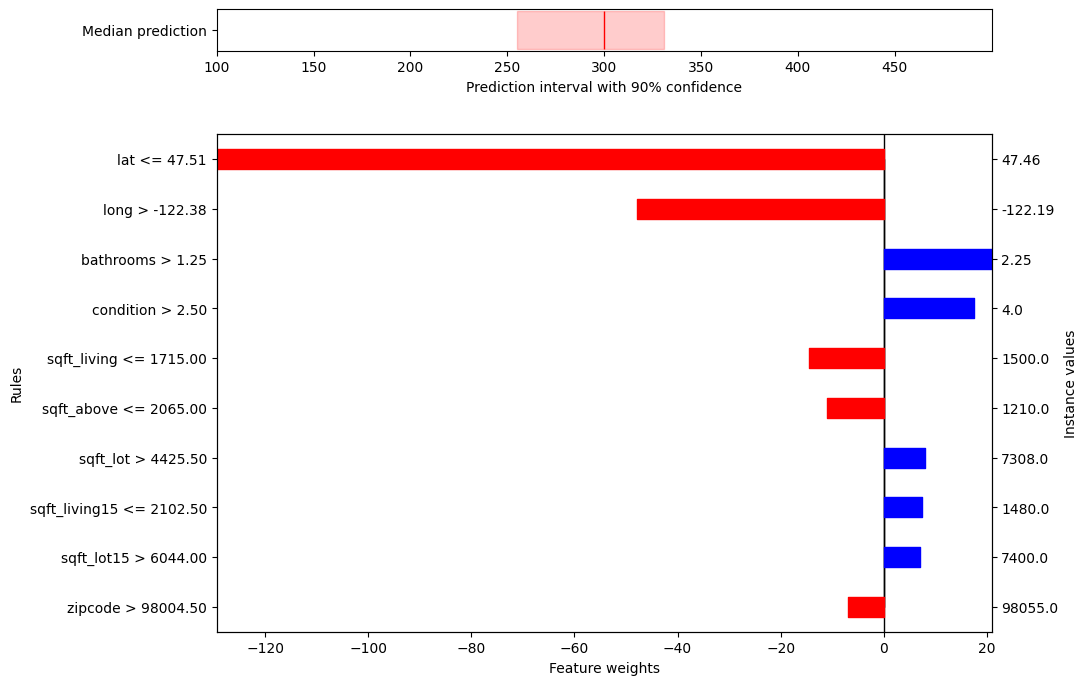

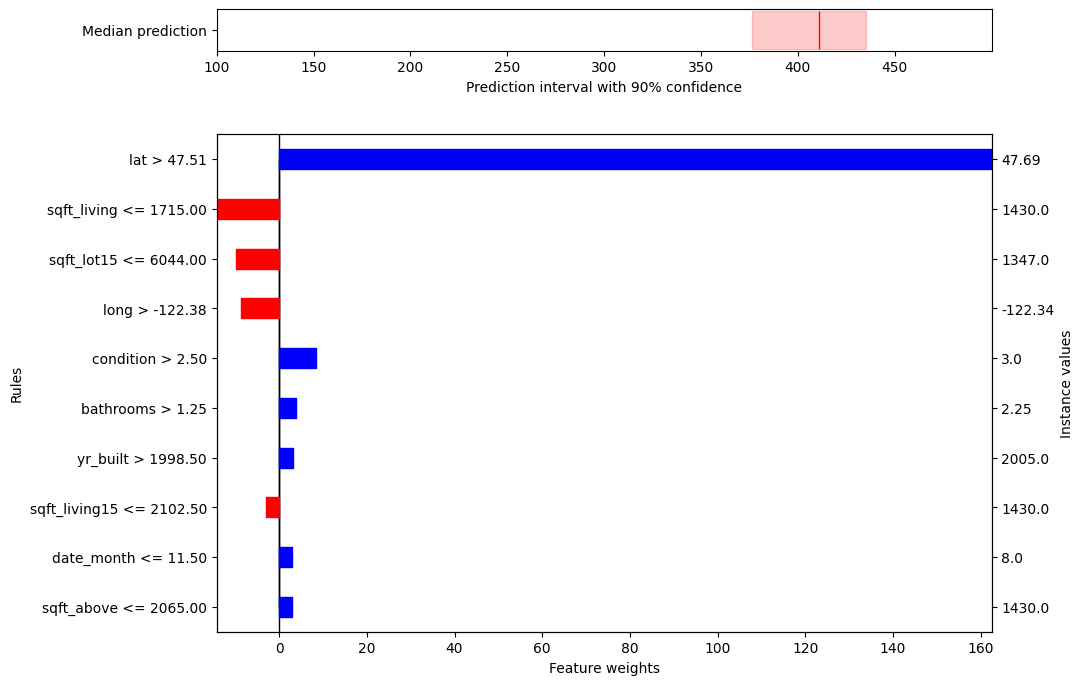

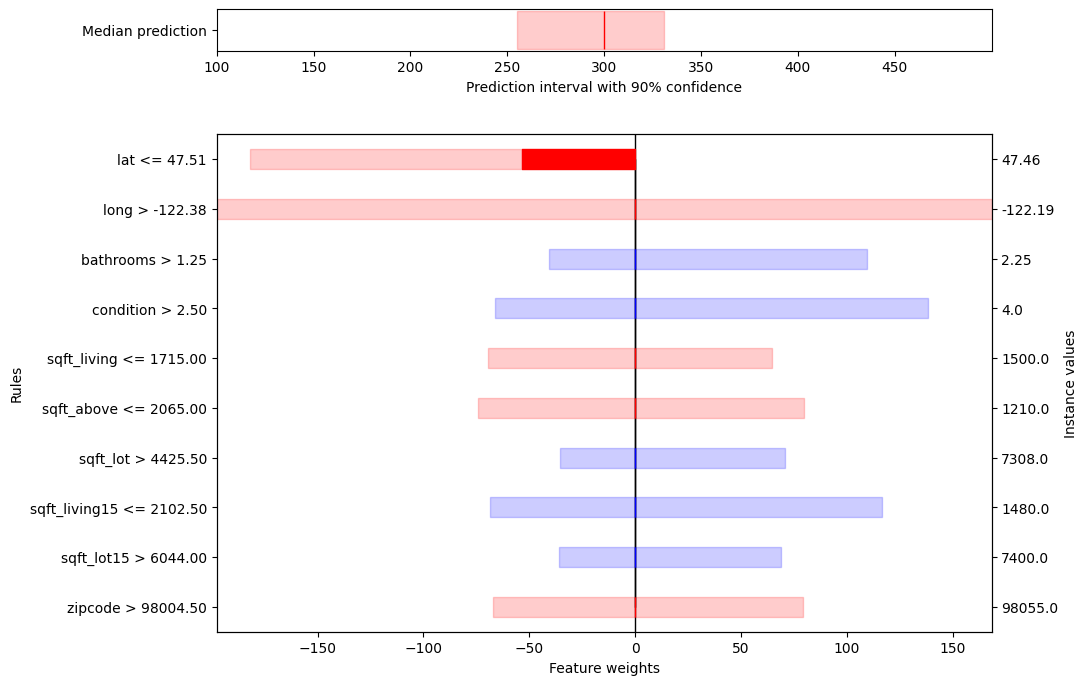

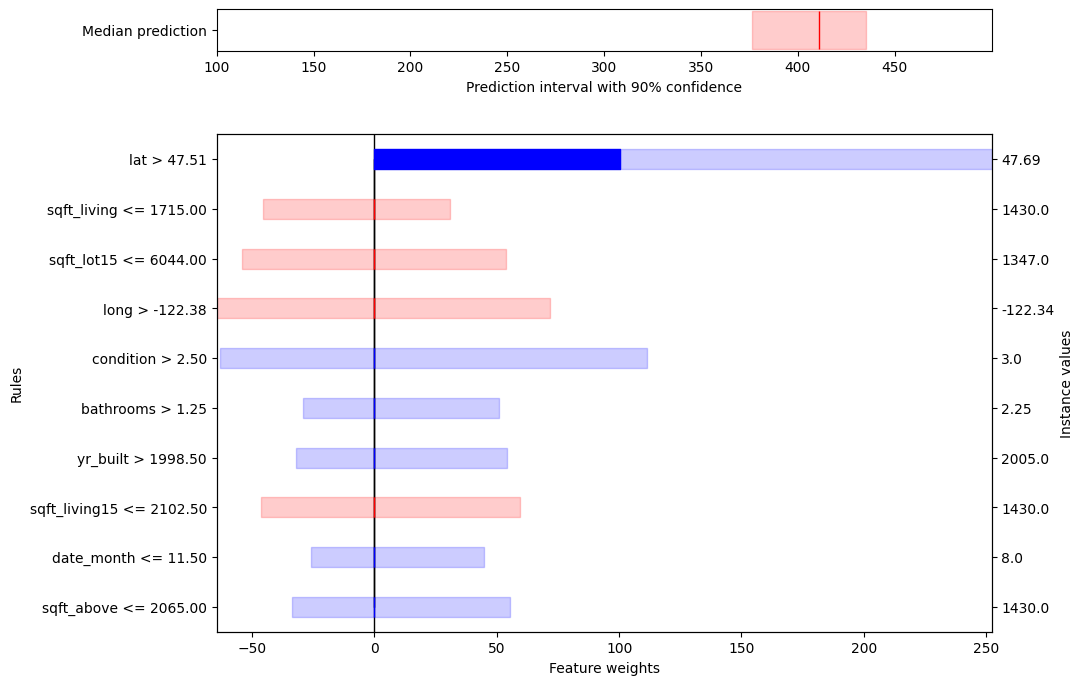

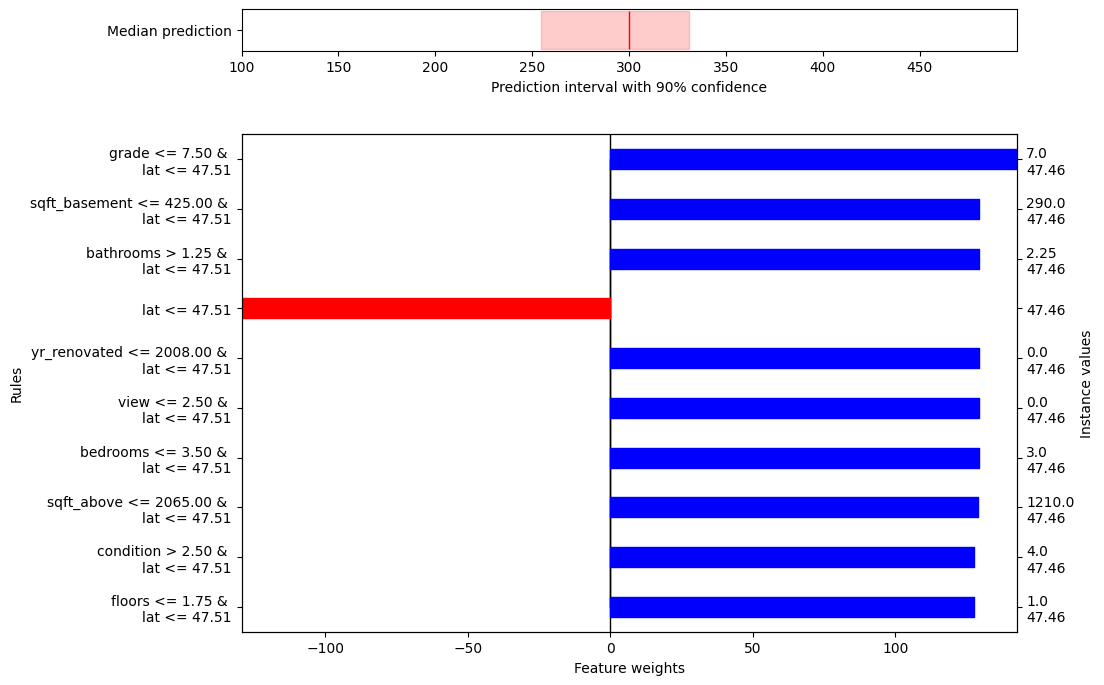

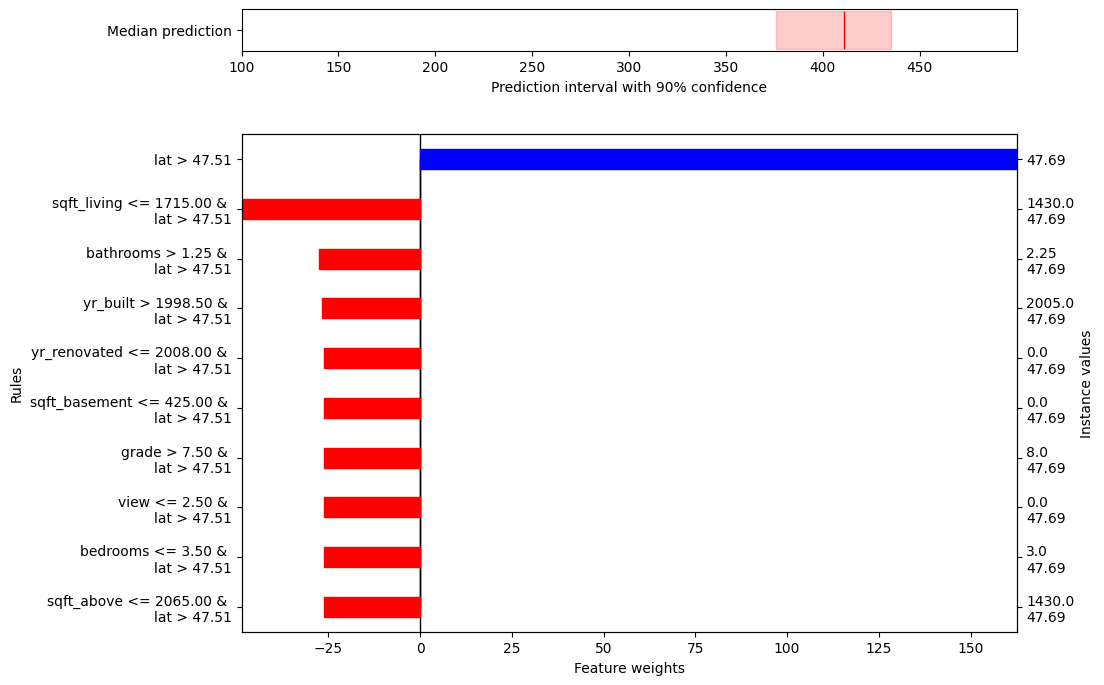

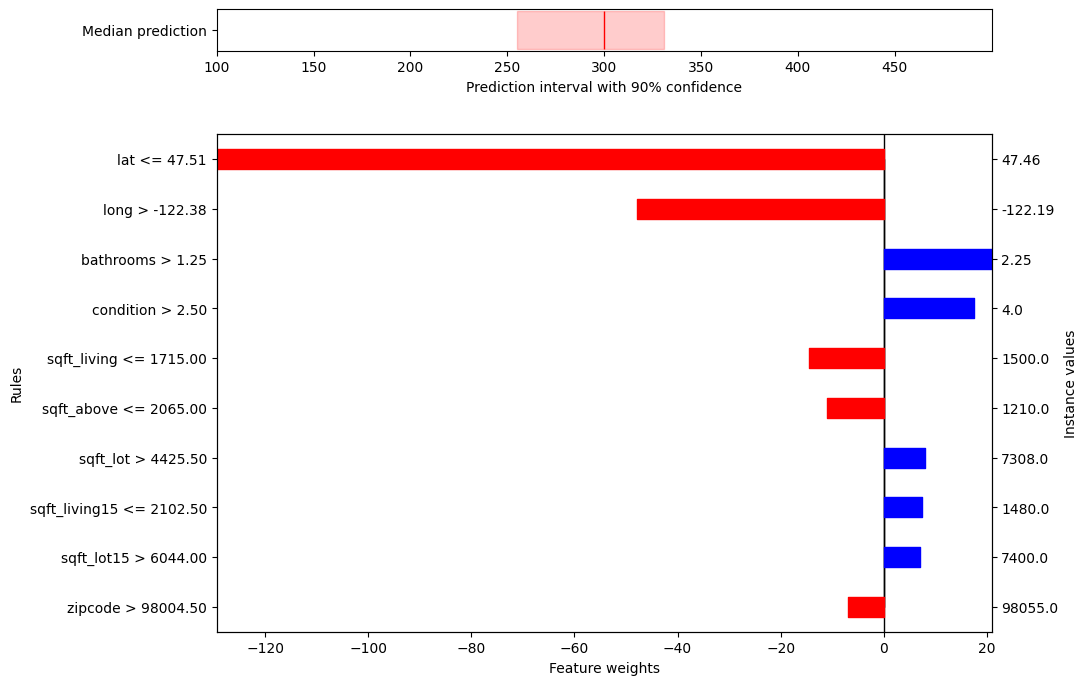

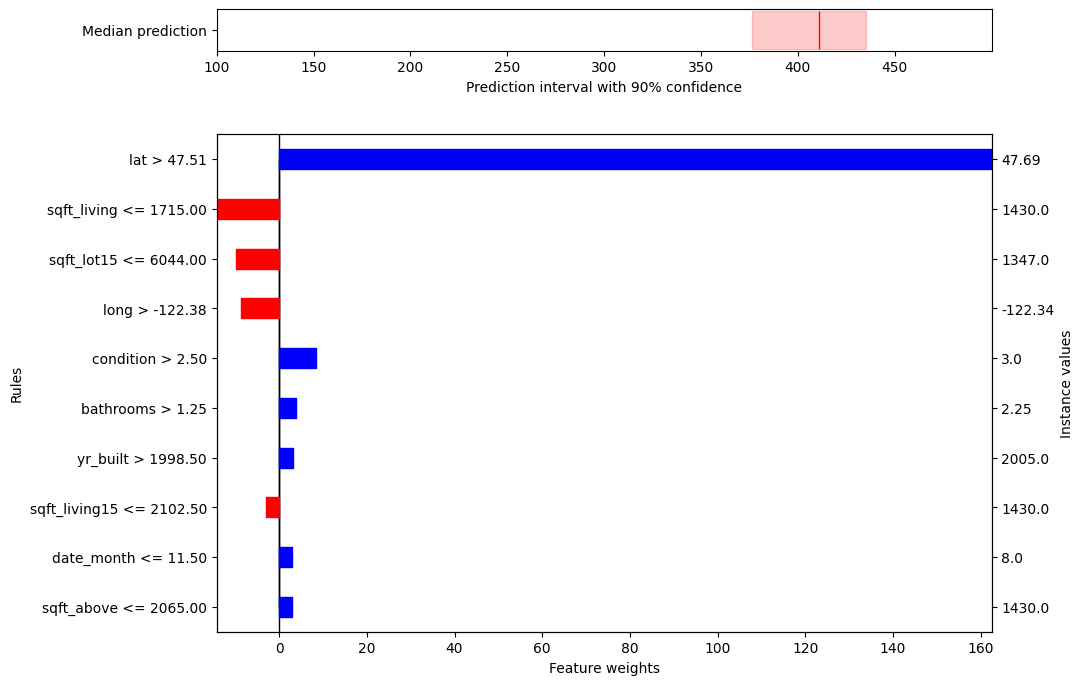

In [54]:
factual_explanations.plot()
factual_explanations.plot(uncertainty=True)

factual_explanations.add_conjunctions().plot()
factual_explanations.remove_conjunctions().plot()

Default, the confidence interval is set to a symmetric interval of 90% (defined as `low_high_percentiles=(5,95)`). The intervals can cover any user specified interval, including one-sided intervals. To define a one-sided upper-bounded 90% interval, set `low_high_percentiles=(-np.inf,90)`, and to define a one-sided lower-bounded 95% interval, set `low_high_percentiles=(5,np.inf)`. Percentiles can also be set to any other values in the range (0,100) (exclusive), and intervals do not have to be symmetric.

In [55]:
import numpy as np
lower_bounded_explanations = explainer.explain_factual(X_test, low_high_percentiles=(5,np.inf))
asymmetric_explanations = explainer.explain_factual(X_test, low_high_percentiles=(5,75))

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


The `explore_alternatives` will work exactly the same as for classification. Otherwise, the discretizer must be set explicitly and the 'decile' discretizer is recommended. Alternative plots work as for classification.

c:\Users\loftuw\AppData\Local\anaconda3\envs\calibrated_explanations_env\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


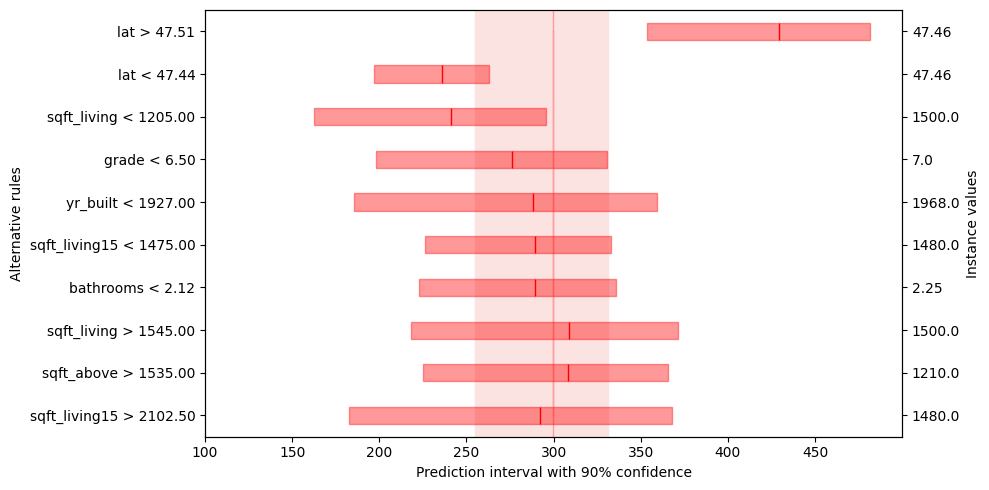

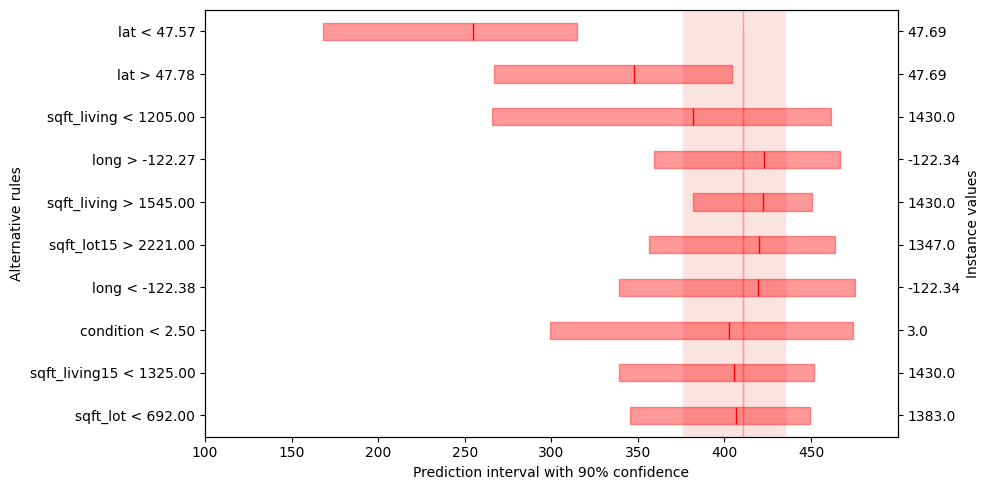

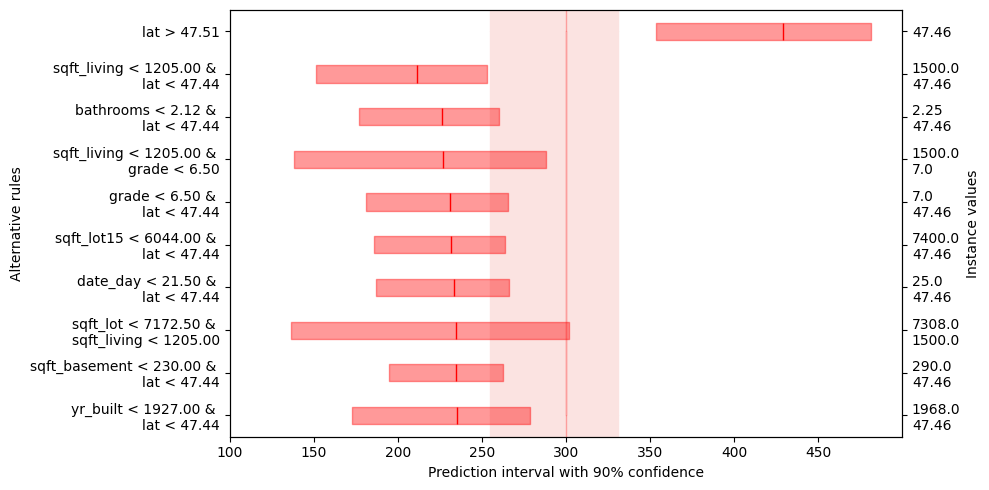

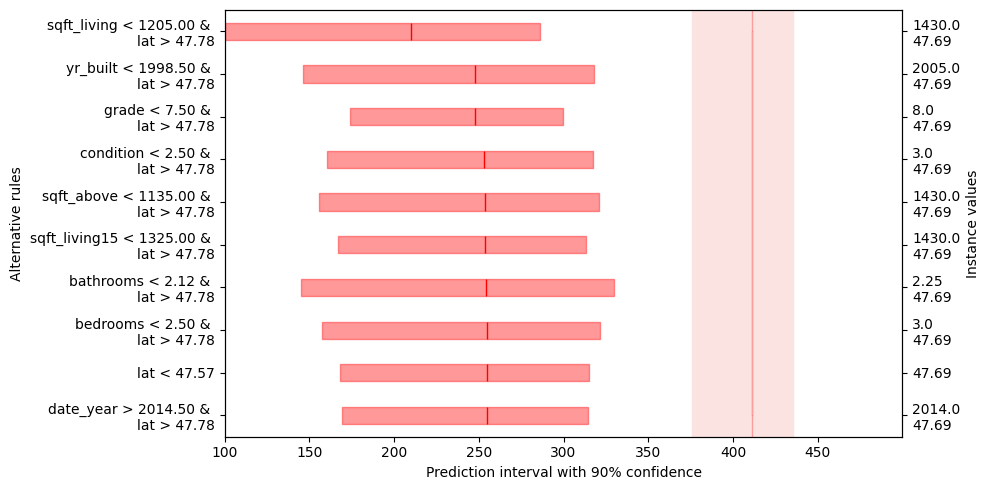

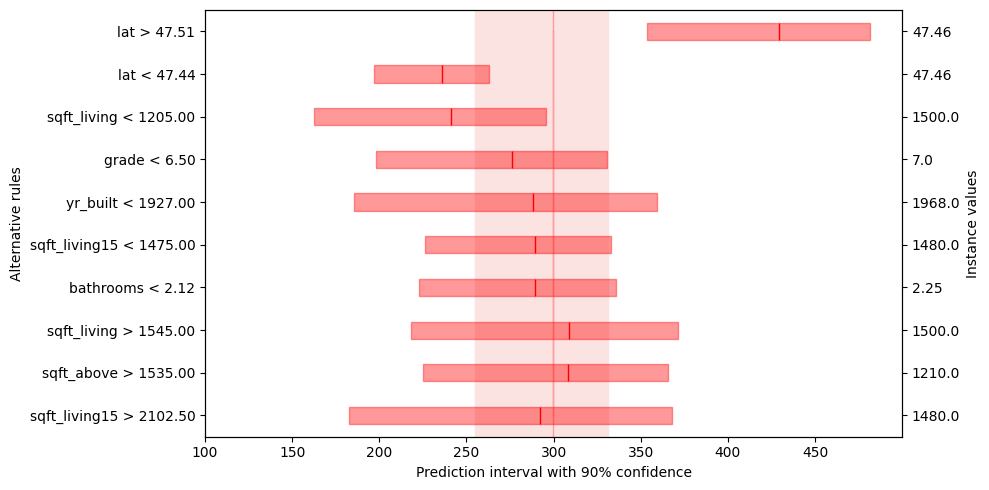

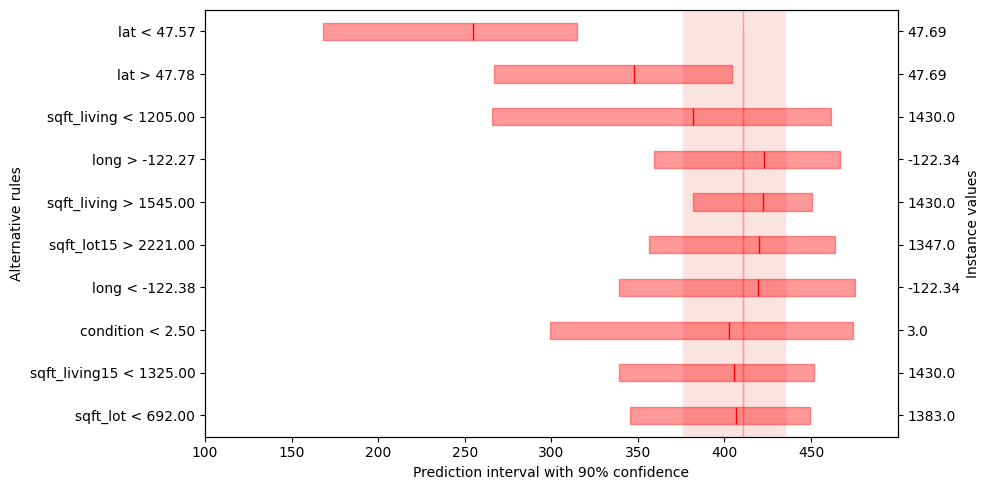

In [56]:
alternative_explanations = explainer.explore_alternatives(X_test)

alternative_explanations.plot()
alternative_explanations.add_conjunctions().plot()
alternative_explanations.remove_conjunctions().plot()

Regression offers many more options but to learn more about them, see the [demo_regression](https://github.com/Moffran/calibrated_explanations/blob/main/notebooks/demo_regression.ipynb) or the [demo_probabilistic_regression](https://github.com/Moffran/calibrated_explanations/blob/main/notebooks/demo_probabilistic_regression.ipynb) notebooks.